In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml
import pickle
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb

from mykaggle.metric.mse import rmse
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '294_ensemble'
competition: atmacup8
description: 'seed averaging'
seed: 1019
training:
    pca_dim: 4
    validation: 'stratified'
    num_folds: 5
    num_rounds: 10000
    early_stopping_rounds: 1000
    verbose_eval: 20
    sample_weight_division: 0.01  # 10/2/1
    sample_weight_threshold: 1000
lgbm_params:
    objective: regression
    learning_rate: 0.01
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
basedir = Path('../ckpt/')
targets = [
    '276_catboost',
    '293_ensemble',
]

weights = [
    1,
    1,
    1,
    1,
    0.5
]

In [7]:
def load_and_concat(targets: List[str], basedir: Path):
    df_sub = []
    for t in targets:
        sub = pd.read_csv(basedir / t / (t + '.csv'))
        df_sub.append(sub)
    df_sub = pd.concat(df_sub, axis=1)
    df_sub.columns = targets
    return df_sub

def make_submission(df_sub: pd.DataFrame, ckptdir: Path, filename: str) -> pd.DataFrame:
    df_sub = df_sub.mean(axis=1).to_frame()
    df_sub.columns = ['Global_Sales']
    df_sub.to_csv(ckptdir / f'{filename}.csv', index=False)

In [8]:
def visualize_oof(
    y_1: np.ndarray, y_2: np.ndarray, label1: str, label2: str, title: str
) -> None:
    plt.figure(figsize=(5, 5))
    plt.plot([-100, 1000], [-100, 1000], color='black')
    plt.scatter(y_1, y_2, alpha=0.2)
    plt.xlim(-100, 1000)
    plt.ylim(-100, 1000)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title(title)

def plot_corr(df: pd.DataFrame, targets: List[str]) -> None:
    num = df.shape[1]
    for i in range(num):
        if i == 0:
            continue
        for j in range(i - 1, -1, -1):
            pred_a = df.iloc[:, j]
            pred_b = df.iloc[:, i]
            label_a = targets[j]
            label_b = targets[i]
            title = f'corr coef: {np.corrcoef(pred_a, pred_b)[0, 1]:.3f}'
            visualize_oof(pred_a, pred_b, label_a, label_b, title)

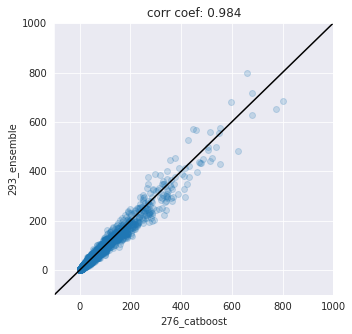

In [9]:
df_sub = load_and_concat(targets, basedir)
make_submission(df_sub, ckptdir, settings['name'])
plot_corr(df_sub, targets)